<a href="https://colab.research.google.com/github/2024-MJU-Capstone-Design/coinmerge-ml/blob/main/Upbit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyupbit

In [ ]:
!pip install lightgbm==3.3.0

# 라이브러리 로드

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import pyupbit

import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_absolute_error

from mlxtend.preprocessing import minmax_scaling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

import lightgbm as lgb
from xgboost import XGBRegressor

In [ ]:
print(pyupbit.Upbit)

<class 'pyupbit.exchange_api.Upbit'>


# 1. 암호화폐 가격 데이터 수집

In [ ]:
BTC = pyupbit.get_current_price("KRW-BTC")
print(BTC)

99305000.0


In [ ]:
coins = pyupbit.get_tickers(fiat="KRW")
len(coins)

119

In [ ]:
# 시초가, 고가, 저가, 종가, 거래량, 거래액
pyupbit.get_ohlcv("KRW-BTC")

,open,high,low,close,volume,value
2023-09-27 09:00:00,35566000.0,36485000.0,35560000.0,35982000.0,3281.146517,1.180054e+11
2023-09-28 09:00:00,35979000.0,36999000.0,35933000.0,36596000.0,2834.062676,1.030971e+11
2023-09-29 09:00:00,36596000.0,36868000.0,36260000.0,36444000.0,1841.587064,6.735557e+10
2023-09-30 09:00:00,36444000.0,36740000.0,36404000.0,36600000.0,1372.416153,5.021821e+10
2023-10-01 09:00:00,36614000.0,37817000.0,36555000.0,37789000.0,2733.222524,1.012743e+11
...,...,...,...,...,...,...
2024-04-09 09:00:00,102050000.0,102399000.0,98400000.0,99350000.0,4778.273799,4.788453e+11
2024-04-10 09:00:00,99409000.0,101750000.0,97614000.0,100600000.0,4307.830870,4.274479e+11
2024-04-11 09:00:00,100601000.0,101452000.0,100031000.0,100541000.0,3026.454431,3.048171e+11
2024-04-12 09:00:00,100542000.0,101426000.0,98985000.0,99776000.0,5005.558568,5.011387e+11


거래 가능한 모든 암호화폐의 하루 단위 데이터를 1년 동안의 기간으로 쌓아둔 데이터 생성
시간 오래 걸림

In [ ]:
from tqdm import tqdm # Progress bar 모듈

In [ ]:
#df = pd.DataFrame()

#for coin in tqdm(coins):
#  tmp = pyupbit.get_ohlcv(coin, count=365)
#  df = pd.concat([df, tmp])

#df

In [ ]:
# 결측치가 존재하는가
#df.isnull().sum().sum()

NameError: name 'df' is not defined

결측치가 존재하지 않으므로 전처리가 필요하지 않음

하지만 유의미한 정보를 뽑아내야 하므로 RSI(Relative Strength Index)를 활용
- `RSI`: 상대강조지수; 가격의 상승 정도와 하락 정도의 상대적 강도를 나타내는 지수

RSI를 정밀하게 구할 수 있으면 암호화폐 가격에 상승 압력이 어느정도로 있는지, 반대로 하강 압력은 얼마나 있는지 정보가 담기게 되어 인공지능에게 더 정확한 예측을 기대할 수 있음

# 2. 데이터 전처리 & 변수 생성

### RSI 구하는 방법
주어진 기간의 모든 가격에 대해서

- 가격이 전일 가격보다 상승한 날의 상승분은 U(up)이라고 하고,
- 가격이 전일 가격보다 하락한 날의 하락분은 D(down) 값이라 한다.
- U 값과 D 값의 평균값을 구하여 그것을 각각 AU(average ups)와 AD(average downs)라고 한다.
- AU를 AD값으로 나눈 것을 RS(relative strength) 값이라고 한다. RS 값이 크다는 것은 일정 기간 하락한 폭보다 상승한 폭이 크다는 것을 의미한다.

다음 계산에 의하여 RSI 값을 구한다.

- RSI 계산공식: RSI = RS / (1 + RS)

$$
\textit{RSI} = \textit{RS} \diagup \textit{(1+RS)}
$$

In [ ]:
## 코인 거래 데이터 다운로드를 위한 함수 설정

def get_df(coin):
  df = pyupbit.get_ohlcv(coin, count=365) # 1년치 데이터 활용
  df_4h = pyupbit.get_ohlcv(coin, interval = 'minute240', count=365*6) # 240분 단위 데이터 활용

  ## 변수 생성
  ## RSI 지표 생성
  df_4h['U'] = df_4h['close'] - df_4h['open']
  df_4h['D'] = df_4h['close'] - df_4h['open']
  df_4h['U'] = np.where(df_4h['U'] > 0, df_4h['U'], 0)
  df_4h['D'] = np.where(df_4h['D'] < 0, df_4h['D'], 0)

  df_4h.index = df_4h.index.strftime("%Y%m%d")
  df.index = df.index.strftime("%Y%m%d")

  df_A = df_4h.reset_index().groupby('index').mean()[['U','D']].reset_index()
  df_A.columns = ['index','AU','AD']

  df = pd.merge(df.reset_index(), df_A, on='index', how='left')
  df['price'] = df['close']*100 / df['open']

  df['RSI'] = df['AU'] / (df['AU'] + df['AD'])
  df.drop(['open','high','low','volume','AU','AD'], axis=1, inplace=True)

  df['RSI'] = df['RSI'].apply(lambda x: df[df['RSI'] != np.inf].max()['RSI'] if x == np.inf else x)
  df['RSI'].describe()

  ## 각 변수의 과거 시점 값을 변수로 생성
  df = pd.concat([df[['index','close','price']],minmax_scaling(df, columns=['value','RSI'])], axis=1)
  lag = np.arange(1,30).tolist()

  close_cols = ['close_' + str(a) for a in lag]
  value_cols = ['value_' + str(a) for a in lag]
  RSI_cols = ['RSI_' + str(a) for a in lag]

  data = pd.DataFrame()
  data['date'] = df['index']
  data['name'] = coin.split('-')[1]

  data['close'] = df['close']
  data['value'] = df['value']
  data['RSI'] = df['RSI']

  for a,b,c,d in zip(lag, close_cols, value_cols, RSI_cols):
    data[b] = df['close'].shift(int(a))
    data[c] = df['value'].shift(int(a))
    data[d] = df['RSI'].shift(int(a))

  time_now = datetime.datetime.now() + datetime.timedelta(days=-5)
  time_now = time_now.strftime("%Y%m%d")

  ## 5일 뒤 종가를 예측 변수로 설정
  data['target'] = df['close'].shift(-5)
  data['target'] = data['target']*100 / df['close']

  data['target'] = np.where(data['date'] <= time_now, data['target'], 100)

  data = data.dropna(axis=0)
  data.reset_index(drop=True, inplace=True)

  return data

In [ ]:
## 설정 함수를 이용한 실제 데이터셋 생성
df = pd.DataFrame()

for coin in tqdm(coins):
  tmp = get_df(coin)
  df = pd.concat([df, tmp])

df.reset_index(drop=True, inplace=True)

100%|██████████| 119/119 [20:34<00:00, 10.38s/it]


위 과정을 마치면 RSI라는 새로운 정보를 가진 데이터가 생성이 완료 된 것임
우리의 목표는 5일 뒤의 암호화폐 가격을 예측하는 것이다.
따라서 최근 데이터의 흐름을 다양하게 보여주는 것이 유리하다.
하지만 우리는 하나의 데이터에 하루 동안에 생성되는 정보만을 담고 있다.
하루 데이터가 아닌 여러 기간의 데이터를 종합적으로 활용하면 더욱 정밀한 예측 시스템을 만들 수 있다.

이를 위해서 마지막으로 특정 시점을 기준으로 1일전 데이터, 2일 전 데이터 ~ 30일 전 데이터를 끌고 들어와서 새로운 데이터셋을 다시 구성
-> 머신러닝 분야에서 **Lag변수 생성**라고
 불리는 방법
 같은 암호화페의 이전 시점의 가격 정보를 새로운 컬럼으로 가져와 여러 시점의 데이터를 동시에 활용하는 방식.
 최종적으로 과거 시점의 데이터를 생성하고 목표일인 5일 뒤의 암호화폐 가격(종속 변수)을 만들며 데이터 셋 생성 과정을 마무리 할 수 있다.

# 3. 머신러닝 모델링 수행

하지만 이 데이터를 모두 사용할 수는 없다.
일반적으로 머신러닝, 딥러닝 등 인공지능 학습 과정을 수행하기 위해서는 **생성한 데이터의 분할작업*이 필요하다.
인공지능을 활용하는데 가장 핵심은 향후 데이터가 들어왔을 때 그 데이터를 기반으로 인공지능이 예측을 할 수 있도록 환경을 구성하는 것임
현 시점에서는 향후 새로운 데이터가 들어왔을 때 얼마나 높은 정확도를 보이며 예측할지 알 수 없음

따라서 학습 데이터셋과 검증 데이터 셋으로 나누어 학습 데이터만 이용해 인공지능을 학습해야함
학습 데이터 셋을 통해 인공지능에게 학습을 진행하고 **학습을 마친 인공지능이 향후 어느 정도의 정확도를 보여줄지를 사전에 떼어 놓았던 검증 데이터 셋을 통해 파악하는 개념**

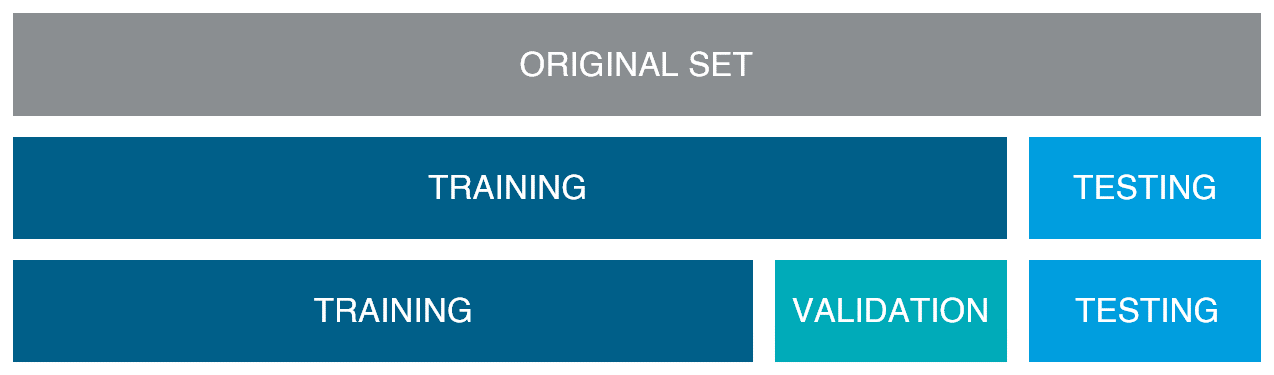

데이터를 학습용, 검증용 셋으로만 분리한다면 검증용 셋에서 원하는 성과가 나오지 않았을 경우 검증용 셋에서 좋은 결과가 나올 때까지 학습을 다시 수행하게 됨
이는 일반적인 데이터가 아닌 검증용 데이터 셋에만 적합하게 학습된 모델을 만들 수 있음
따라서 최종 테스트를 위한 데이터를 따로 떼어두고 나머지 중 학습과 검증용 셋을 다시 만들어 학습하도록 한다.

In [ ]:
## 학습, 예측 셋 구분 (최근 5일치 기준)
time_now = datetime.datetime.now() + datetime.timedelta(days=-5)
time_now = time_now.strftime("%Y%m%d")

Train = df[df['date'] <= time_now]
Test = df[df['date'] > time_now]

Train.reset_index(drop = True, inplace=True)
Test.reset_index(drop = True, inplace=True)

## 활용 변수 셋팅
cols = df.columns.tolist()
cols.remove('target')
cols.remove('name')
cols.remove('date')

## 학습용, 검증용 데이터 셋 분리
X_train, X_valid, y_train, y_valid = train_test_split(Train[cols], Train['target'], train_size=0.8, random_state=42)

위 예제에서는 가장 최근 5일치의 데이터를 모두 최종 테스트용 데이터로 이용함
나머지 데이터 중에서는 랜덤하게 데이터를 분할함
테스트 데이터를 제외한 데이터 중 80%는 학습용 데이터, 20%는 검증용 데이터로 활용하여 인공지능에 제공

인공지능 분야에는 머신러닝, 딥러닝을 포함하여 매우 다양한 모델들이 존재한다.
그 모델 중 머신러닝 분야에서는 XGBoost, LightGBM, RandomForest 등의 모델이 유명세와 인기가 있다.
이 중 우리는 **XGBoost와 LightGBM** 모델을 활용해서 실제 인공지능 모델을 만들고 학습을 진행한다.

XGBoost와 LightGBM은 모두 부스팅이라는 개념을 활용한 인공지능 모델이다.
부스팅은 앙상블 모델 중 하나로 앙상블은 여러 가지 모델의 결과를 종합하여 사용하는 머신러닝 용어이다.
XGBoost와 LightGBM은 모두 의사결정나무(Dicision Tree)라는 모델을 복수로 이용하여 앙상블을 한다.
또한 앙상블을 할 시 잘못 예측한 경우에 가중치를 두어 데이터셋을 다시 생성하고 학습을 재진행하게 되는데 이를 **부스팅 기법**이라고 한다.
그리고 파이썬 프로그램은 간단하게 XGBoost, LightGBM을 구현할 수 있도록 모든 기능을 제공하고 있다.

In [ ]:
## XGB를 이용한 머신러닝
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)
print(mean_absolute_error(y_valid, y_pred))

6.825839356001165


In [ ]:

## LGBM을 활용한 머신러닝 적용
train, valid = train_test_split(Train, train_size=0.8, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(Train[cols], Train['target'], train_size=0.8, random_state=42)

## LGB
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_valid, label=y_valid)

## 파라미터 셋팅
params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'mae',
    'sub_row': 0.75,
    'lambda_l2': 0.1
}

## 모델 학습
model_t = lgb.train(params,
                    train_ds,
                    2000,
                    val_ds,
                    verbose_eval = 100,
                    early_stopping_rounds = 100,
                    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
                    )

y_pred = model_t.predict(valid[cols])
print(mean_absolute_error(valid['target'], y_pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 29640, number of used features: 90
[LightGBM] [Info] Start training from score 4.619216
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 6.81456
[100]	valid_0's l1: 6.77657
[100]	valid_0's l1: 6.77657
[150]	valid_0's l1: 6.7464
[200]	valid_0's l1: 6.72684
[200]	valid_0's l1: 6.72684
[250]	valid_0's l1: 6.70005
[300]	valid_0's l1: 6.67928
[300]	valid_0's l1: 6.67928
[350]	valid_0's l1: 6.6558
[400]	valid_0's l1: 6.63854
[400]	valid_0's l1: 6.63854
[450]	valid_0's l1: 6.62419
[500]	valid_0's l1: 6.61475
[500]	valid_0's l1: 6.61475
[550]	valid_0's l1: 6.60719
[600]	valid_0's l1: 6.59648
[600]	valid_0's l1: 6.59648
[650]	valid_0's l1: 6.58854
[7

# 4. 모델 결과 평가
앞서 모델을 학습하였고 그 모델의 결과를 평가해야한다.
이를 위해 검증용 데이터 셋을 따로 남겨두었고 XGBoost, LGBM 두 인공지능 모델을 생성하였다.
이제 인공지능 모델에게 따로 떼어둔 검증용 데이터 셋을 건네주어 새롭게 예측을 실행하도록 해보고 그 결과가 어느정도인지를 판단하는 과정을 거쳐야한다.

XGBoost 모델을 사용한 인공지능 검증용 데이터 셋에 대한 모델 성능 지표는 아래와 같다.
이 결과를 잘 이해하기 위해서는 우선 mean_absolute_error라는 지표에 대한 이해가 선행되어야 한다.
MAE라는 약어로 불리며 오차의 절대적인 평균값 정도로 해석해볼 수 있다.
우리가 예측한 암호화폐 5일 뒤 가격의 변화율이 실제 가격 변화율과 어느 정도의 차이를 보이는지를 지표화 했다는 의미를 담고 있다.
만약 MAE가 1로 나온다면 평균적으로 변화율에 1 정도의 예측 오차가 있음을 의미한다.

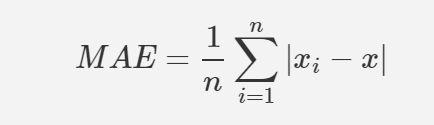

다시 돌아와 우리는 5일 뒤 특정 암호화폐 가격의 변화율을 예측 대상으로 삼았다. 만약 101이라는 수치가 도출된다면 5일 뒤 해당 암호화폐는 1% 가격 상승을 보인다는 의미이다.
그리고 실제 XGBoost 모델의 MAE 성능을 보면 약 6.8를 기록하고 있다.
이를 해석해보면 XGBoost를 활용한 인공지능 모델이 예측한 5일뒤 암호화폐 가격의 변화율은 약 6.8만큼의 오차를 기록할 것을 의미한다.
즉, XGBoost 인공지능 모델이 만약 5% 상승이라는 변화를 예측했다면 실제로는 -4.6% 14.4% 사이의 변화가 있을 확률이 높다는 것을 뜻합니다.

다만 MAE 하나만으로 인공지능의 성능을 평가한다면, 데이터 및 인공지능에 전문적인 지식을 가지고 있는 사람들은 직관적으로 그 성능을 체감할 수  있지만 그렇지 않은 사람들에게는 이 수치가 어느 정도인지 감이 안 올 수 있다.
보통의 경우 인공지능 성능의 체감을 위해서는 인공지능 예측한 값과 실제 값을 나란히 두고 비교하는 것이 가장 효과가 좋다. 이를 고려해, 인공지능이 가장 정확하게 에측한 사례와 가장 부정확하게 예측한 사례를 각 10개 씩 가져오면 다음과 같은 결과를 확인할 수 있다.

In [ ]:
## 예측값과 실제값의 차이 확인
tmp = pd.DataFrame()
tmp['pred'] = y_pred
tmp['true'] = y_valid

## 예측이 잘 된 경우와 되지 않은 경우 확인
tmp['diff'] = abs(tmp['pred'] - tmp['true'])
display(tmp.sort_values('diff', ascending = True).head(10), tmp.sort_values('diff', ascending = False).head(10))


,pred,true,diff
3427,100.035118,100.000000,0.035118
2208,99.541573,99.498328,0.043245
5987,100.524773,100.569260,0.044487
3108,97.278389,97.333333,0.054944
3594,98.327774,98.271479,0.056295
6715,101.440910,101.376652,0.064258
4235,98.213005,98.148148,0.064857
3038,98.946434,99.023710,0.077276
5464,97.850433,97.938144,0.087711
1346,99.499977,99.410029,0.089948


,pred,true,diff
6521,102.083229,270.103093,168.019864
3601,99.266998,196.372549,97.105551
4800,102.216164,190.542420,88.326256
5011,96.981827,181.621622,84.639795
2153,98.784698,181.453634,82.668936
5140,101.222168,179.635762,78.413594
5139,100.365410,169.614148,69.248738
4457,102.000328,162.219851,60.219523
6526,100.556999,42.137405,58.419595
6914,99.593369,157.282886,57.689517


확인결과 가격의 변화율을 잘 맞출 때는 0.03% 차이로 변화율을 예측할 수 있지만 168% 정도 차이가 날 정도로 예측을 못하는 경우도 동시에 발생한다.
그리고 인공지능 모델을 평가할 때 가장 중요한 점 하나는 모델이 어떤 데이터에 적용되든 고른 성능을 보여주는 것이 좋다는 점이다.
이를 고려했을 때 성능 편차가 크기에 XGBoost는 한계가 뚜렷하다.

같은 원리로 LGBM의 모델 성능 역시 평가하는 것이 가능하다.
LGBM의 MAE는 6.5로 XGBoost의 6.9보다 약소하게 좋은 성능을 기록하고 있음을 알 수 있다.
따라서 일단 LGBM으로 예측을 진행한다.

In [ ]:
## LGBM의 K-Fold 적용
train_set, valid_set = train_test_split(Train,train_size=0.85,random_state=42)
X_train = train_set[cols]
y_train = train_set['target']
X_valid = valid_set[cols]
y_valid = valid_set['target']

## 10 Fold Cross Validation
y_cat = pd.cut(y_train, 10, labels=range(10))
skf = KFold(5)

## 파라미터 셋팅
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'mae',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

preds = []
preds_test = []

i = 1
## 실제 학습 진행
for tr_id, val_id in skf.split(X_train, y_cat) :
    X_tr = X_train[cols].iloc[tr_id]
    y_tr = y_train.iloc[tr_id]

    train_x, valid_x, train_y, valid_y = train_test_split(X_tr, y_tr, train_size=0.8,random_state=42)
    train_ds = lgb.Dataset(train_x, label=train_y)
    val_ds = lgb.Dataset(valid_x, label=valid_y)

    print('{}번째 학습'.format(i))
    model = lgb.train(params,
                  train_ds,
                  2000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )
    pred = model.predict(X_valid[cols])
    preds.append(pred)
    i += 1

    pred_test = model.predict(Test[cols])
    preds_test.append(pred_test)

## 예측값 생성 및 점수 확인
model_pred = np.mean(preds, axis = 0)
print(mean_absolute_error(y_valid, model_pred))

1번째 학습
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 20155, number of used features: 90
[LightGBM] [Info] Start training from score 4.619189
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6.54364
[200]	valid_0's l1: 6.50022
[300]	valid_0's l1: 6.46631
[400]	valid_0's l1: 6.43465
[500]	valid_0's l1: 6.42055
[600]	valid_0's l1: 6.3994
[700]	valid_0's l1: 6.39046
[800]	valid_0's l1: 6.38733
[900]	valid_0's l1: 6.37281
[1000]	valid_0's l1: 6.36401
[1100]	valid_0's l1: 6.35323
[1200]	valid_0's l1: 6.34668
[1300]	valid_0's l1: 6.34101
[1400]	valid_0's l1: 6.33096
[1500]	valid_0's l1: 6.31378
[1600]	valid_0's l1: 6.30847
[1700]	valid_0's l1: 6.29821
[1800]	valid_0's l1: 6.29533
[1900]	valid_0's l1: 6.29142
[2000]	valid_0's l1: 6.28691
Did not meet ea

# 결과 확인

In [ ]:
## 최종 예측된 데이터셋 생성
final_pred = np.mean(preds_test, axis = 0)

final = pd.DataFrame()
final['coin'] = Test['name']
final['date'] = Test['date']
final['preds'] = final_pred

In [ ]:
## 가장 상승할 것으로 예측되는 암호화폐 확인
final[final['date'] == final['date'].max()].sort_values('preds', ascending = False)[:10]

,coin,date,preds
169,CVC,20240413,108.340974
379,HUNT,20240413,106.533404
364,CRO,20240413,106.276784
214,BSV,20240413,105.778063
204,ELF,20240413,104.933610
89,ADA,20240413,104.352962
154,BCH,20240413,104.286266
104,BTG,20240413,104.161981
219,THETA,20240413,103.786341
29,ETC,20240413,103.647518


In [ ]:
## 가장 하락할 것으로 예측되는 암호화폐 확인
final[final['date'] == final['date'].min()].sort_values('preds', ascending = False)[:10]

,coin,date,preds
580,ID,20240409,108.197220
165,CVC,20240409,106.506186
0,BTC,20240409,104.601731
345,XTZ,20240409,103.536830
360,CRO,20240409,103.224311
340,LINK,20240409,102.896949
125,ONT,20240409,102.729826
185,ONG,20240409,102.495902
205,KNC,20240409,102.391851
150,BCH,20240409,102.375284
